# Computer Vision - Project
## imports

In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten, BatchNormalization, ZeroPadding2D, GlobalMaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from tqdm import tqdm
from pathlib import Path
import splitfolders
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GaussianNoise
from keras import regularizers
from download_h5py_db import download_h5py_db
from sklearn.metrics import classification_report
import utils

## Constants

In [19]:
FILE_NAME ="SynthText_train.h5"
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
tf.keras.backend.clear_session()
num_classes = 5
if Path(FILE_NAME).exists():
  db = h5py.File(FILE_NAME, 'r')
main_directory='main_directory'
main_directory_splitted='main_directory_splitted'


## Helper Functions

In [20]:
def draw_training_curve(history):
	"""
	Draw training curve
	Parameters:
		history - contains loss and accuracy from training
	Returns:
		None
	"""
	plt.figure(1)

	# History for accuracy
	plt.subplot(211)
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title('model accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'test'], loc='upper left')

	# History for loss
	plt.subplot(212)
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title('model loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'test'], loc='upper left')

	plt.show()

### Get data

In [21]:
def get_data_set(db, size: int):   
    utils.create_dirs(main_directory)
    im_names = list(db['data'].keys())
    num = 0
    for i in tqdm(range(0, len(im_names))):
        im = im_names[i]
        img, fonts, txts, charBBs, wordBBs = utils.get_image_data(db, im)
        font_indx = 0 
        char_indx = 0
        for j in range(0, len(txts)):
            if(j%20!=0):
                cropped = utils.prepare_img(img, wordBBs, j, size)
                path = main_directory+'/'+fonts[font_indx].decode('UTF-8')+'/'+im+'_'+str(num)+'.png' 
                tf.keras.utils.save_img(path,cropped)
                num+=1
                for k in range(0, len(txts[j])):
                    if(utils.is_num_or_letter(txts[j][k])):
                        cropped = utils.prepare_img(img, charBBs, char_indx, size)
                        path = main_directory+'/'+fonts[font_indx].decode('UTF-8')+'/'+im+'_'+str(num)+'.png'
                        tf.keras.utils.save_img(path,cropped)
                        num+=1
                    char_indx+=1
            else:
                char_indx += len(txts[j])
            font_indx += len(txts[j])
    print(num)

In [22]:

if not Path(main_directory).exists():
    download_h5py_db()
    db = h5py.File(FILE_NAME, 'r')
    get_data_set(db, utils.SIZE)


100%|██████████| 998/998 [03:28<00:00,  4.79it/s]

32061


In [23]:

if not Path(main_directory_splitted).exists():
    splitfolders.ratio(main_directory, # The location of dataset
                    output=main_directory_splitted, # The output location
                    seed=42, # The number of seed
                    ratio=(.9, .1), # The ratio of splited dataset
                    group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                    move=False # If you choose to move, turn this into True
                    )

Copying files: 32061 files [00:45, 708.94 files/s]


### Augment data

In [12]:
def data_augmentation():
    datagen =  ImageDataGenerator(
        horizontal_flip=True, rotation_range=90, fill_mode='reflect', channel_shift_range=0.8,#
         shear_range=15,vertical_flip=False, brightness_range=(0.2, 0.8),# 
     rescale=1/255, dtype='float32'
     )
    it = datagen.flow_from_directory(main_directory_splitted+'/train/', batch_size=18, class_mode='categorical', target_size=(utils.SIZE,utils.SIZE),
     shuffle=True, seed=1, keep_aspect_ratio=True)
    datagen_val =  ImageDataGenerator(
     rescale=1/255, dtype='float32'
     )
    val_it = datagen_val.flow_from_directory(main_directory_splitted+'/val/', batch_size=18, class_mode='categorical',  target_size=(utils.SIZE,utils.SIZE),
     shuffle=True)
    return it, val_it, datagen

In [24]:
it, val_it, datagen = data_augmentation()

Found 28852 images belonging to 5 classes.
Found 3209 images belonging to 5 classes.


### Create Model

In [30]:

early_stopping=callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')
filepath="res/res_model3.h5"
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [early_stopping,checkpoint]

In [35]:
baseModel = tf.keras.applications.ResNet50(include_top=False, classes=num_classes,
                         input_shape=(utils.SIZE, utils.SIZE, 3),
                        weights='imagenet')
headModel = baseModel.output
headModel = Dropout(0.3)(headModel)
headModel = GaussianNoise(0.2)(headModel)
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01))(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(num_classes, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)    
model.compile(optimizer=tf.keras.optimizers.Adam(0.00003), loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
# model.fit(X_train, Y_train, batch_size=16, epochs=20)
# datagen.fit(X_train)
# if not os.path.isfile('model_res.h5'):
history = model.fit(it, epochs=30, shuffle=True, validation_data=val_it, verbose=1
            ,callbacks=callbacks_list
            )
# else:
#   model = tf.keras.models.load_model('model_res.h5')

Epoch 1/30
1603/1603 [==============================] - ETA: 0s - loss: 5.7812 - accuracy: 0.3681
Epoch 1: val_loss improved from inf to 5.05797, saving model to res\res_model3.h5
1603/1603 [==============================] - 435s 267ms/step - loss: 5.7812 - accuracy: 0.3681 - val_loss: 5.0580 - val_accuracy: 0.5030
Epoch 2/30
1603/1603 [==============================] - ETA: 0s - loss: 4.4936 - accuracy: 0.5329
Epoch 2: val_loss improved from 5.05797 to 3.86660, saving model to res\res_model3.h5
1603/1603 [==============================] - 404s 252ms/step - loss: 4.4936 - accuracy: 0.5329 - val_loss: 3.8666 - val_accuracy: 0.6089
Epoch 3/30
1603/1603 [==============================] - ETA: 0s - loss: 3.4349 - accuracy: 0.6008
Epoch 3: val_loss improved from 3.86660 to 2.92485, saving model to res\res_model3.h5
1603/1603 [==============================] - 443s 276ms/step - loss: 3.4349 - accuracy: 0.6008 - val_loss: 2.9248 - val_accuracy: 0.6326
Epoch 4/30
1603/1603 [===================

0.3722 - 0.4952

In [38]:
print(model.summery)

AttributeError: 'Functional' object has no attribute 'summery'

In [39]:
score = model.evaluate(val_it)

179/179 [==============================] - 12s 67ms/step - loss: 0.5152 - accuracy: 0.8302


score = model.evaluate(test_it)

In [40]:
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.515245795249939 / Test accuracy: 0.8301651477813721


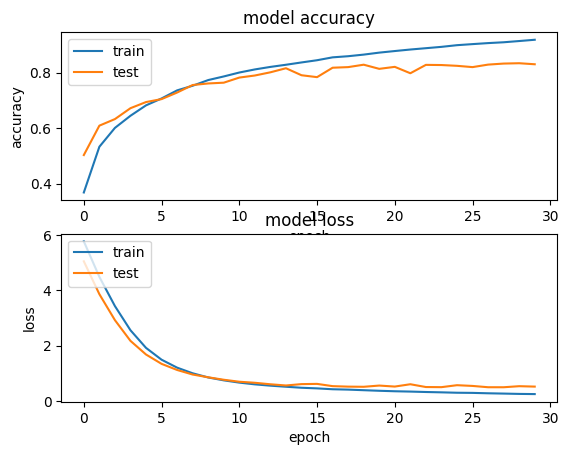

In [41]:
draw_training_curve(history)

In [88]:
model = tf.keras.models.load_model('res//res_model3.h5')

In [89]:
model.evaluate(val_it)

179/179 [==============================] - 13s 67ms/step - loss: 0.4917 - accuracy: 0.8327


[0.4916921854019165, 0.8326581716537476]

In [50]:
def crop_and_save(img, BBs, indx, size, curr_font, im, num, append_not_save=False, folder='main_directory/'):
    cropped = utils.prepare_img(img, BBs, indx, size)
    if not append_not_save:
        path = folder+curr_font.decode('UTF-8')+'/'+im+'_'+str(num)+'.png' 
        tf.keras.utils.save_img(path,cropped)
    return cropped

In [80]:
def prepare_img(img, bbs, index, size = utils.SIZE):
    x1 = int(bbs[0,0,index])
    y1 = int(bbs[1,0,index])
    x2 = int(bbs[0,1,index])
    y2 = int(bbs[1,1,index])
    x3 = int(bbs[0,2,index])
    y3 = int(bbs[1,2,index])
    x4 = int(bbs[0,3,index])
    y4 = int(bbs[1,3,index])
    # calculate bounding rectangle
    top_left_x = max(0, min([x1,x2,x3,x4]))
    top_left_y = max(0, min([y1,y2,y3,y4]))
    bot_right_x = max(0, max([x1,x2,x3,x4]))
    bot_right_y = max(0, max([y1,y2,y3,y4]))

    cropped = img[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1]
    # _, cropped = cv2.threshold(cropped,127,255,cv2.THRESH_TRIANGLE)
    # print(cropped.shape)
    cropped = tf.image.resize(cropped, (size, size), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # cropped = tf.image.rgb_to_grayscale(cropped)
    # # print(cropped.shape)
    cropped = tf.image.convert_image_dtype(cropped, tf.float32)
    # plt.imshow(cropped, cmap='gray')
    # plt.show()
    return cropped

In [81]:
def create_dirs(main_dir):
    Path(main_dir).mkdir(parents=True, exist_ok=True)
    Path(main_dir+'/Alex Brush').mkdir(parents=True, exist_ok=True)
    Path(main_dir+'/Titillium Web').mkdir(parents=True, exist_ok=True)
    Path(main_dir+'/Sansation').mkdir(parents=True, exist_ok=True)
    Path(main_dir+'/Open Sans').mkdir(parents=True, exist_ok=True)
    Path(main_dir+'/Ubuntu Mono').mkdir(parents=True, exist_ok=True)

In [82]:
def font_to_num(font):
    if font == b'Alex Brush':
        return 0
    elif font == b'Open Sans':
        return 1
    elif font == b'Sansation':
        return 2
    elif font == b'Titillium Web':
        return 3
    else:
        return 4

In [83]:
def get_image_data(db, im):
    img  = db['data'][im][:]
    fonts = db['data'][im].attrs['font']
    txts = db['data'][im].attrs['txt']
    charBBs = db['data'][im].attrs['charBB']
    wordBBs = db['data'][im].attrs['wordBB']
    return img, fonts, txts, charBBs, wordBBs

In [108]:
from sklearn.preprocessing import normalize
create_dirs('test_set')
size=utils.SIZE
im_names = list(db['data'].keys())
num = 0
prediction_arr=[]
test_y = []
test_x_total = []
test_y_total = []
for i in tqdm(range(0, int(len(im_names)))):
    im = im_names[i]
    img, fonts, txts, charBBs, wordBBs = get_image_data(db, im)
    font_indx = 0 
    char_indx = 0
    
    # print(im)
    for j in range(0, len(txts)):
        if(j%8==0): 
            curr_font = fonts[font_indx]
            test_x = [] 
            cropped = crop_and_save(img, wordBBs, j, size, curr_font, im, num, False, 'test_set/')
            test_x.append(cropped)
            test_x_total.append(cropped)
            test_y_total.append(font_to_num(curr_font))
            # test_y.append(font_to_num(curr_font))
            num+=1            
            for k in range(0, len(txts[j])):
                # if(is_num_or_letter(txts[j][k])):
                cropped = crop_and_save(img, charBBs, char_indx, size, curr_font, im, num, False, 'test_set/')
                test_x.append(cropped)
                # test_x_total.append(cropped)
                # test_y_total.append(font_to_num(curr_font))
                    # test_y.append(font_to_num(curr_font))
                num+=1
                char_indx+=1
            test_x = np.asarray(test_x, dtype=np.float32)
            # # print(test_x)
            reses = model.predict(test_x, verbose=0)
            # # print(reses)
            maxes = np.argmax(reses, axis=1)
            # print(np.bincount(maxes))
            prediction = np.bincount(maxes)
            prediction = (prediction==prediction.max()).argmax()
            # prediction = np.argwhere(prediction==prediction.max())
            # if (len(prediction)>1):
            #     sum_p = reses.sum(axis=0)
            #     prediction = sum_p.argmax()

                # if(font_to_num(curr_font)!=prediction):
                #     # print(sum_p)
                #     reses_n = normalize(reses, axis=1, norm='l1')
                #     maxes_n = np.argmax(reses_n, axis=1)
                #     # print(np.bincount(maxes))
                #     prediction = np.bincount(maxes_n)
                #     prediction = np.argmax(prediction)
                #     if(font_to_num(curr_font)!=prediction):
                #         sum_p = np.sum(reses, axis=0)
                #         prediction = sum_p.argmax()
                #     # # print(reses[0]/np.sum(reses, axis=1)[0])
                #     #     print(maxes)
                #     # print(prediction)
                #     # plt.imshow(test_x[0])
                #     # plt.show()
                    # print(prediction)
                    # print(font_to_num(fonts[font_indx]))
            for k in range(0, len(txts[j])):
                test_y.append(font_to_num(fonts[font_indx]))
                prediction_arr.append(prediction.item())
                # print(prediction.item())
            # if(font_to_num(curr_font)!=prediction):
            #     plt.imshow(test_x[0])
            #     plt.show()
            #     print(maxes)
            #     print(reses)
            #     print(prediction)
            #     print(font_to_num(fonts[font_indx]))
            #     print('----------------------')
            # print(num_to_font(prediction))
                        # print(test_x)
            # print(str(np.bincount(maxes).argmax())+"-"+str(font_to_num(fonts[font_indx])))
            # print(np.bincount(maxes).argmax())
        else:
            char_indx+=len(txts[j])
        font_indx += len(txts[j])

100%|██████████| 998/998 [03:13<00:00,  5.16it/s]


Check with arrays per image

In [109]:
print(len(prediction_arr))
print(len(test_y))

5694
5694


In [110]:

labels=['Alex Brush','Open Sans','Sansation','Titillium Web','Ubuntu Mono']
print(classification_report(test_y, prediction_arr, target_names=labels))

               precision    recall  f1-score   support

   Alex Brush       0.90      0.98      0.94      1137
    Open Sans       0.78      0.88      0.83       970
    Sansation       0.84      0.81      0.82      1196
Titillium Web       0.95      0.80      0.87      1127
  Ubuntu Mono       0.95      0.95      0.95      1264

     accuracy                           0.89      5694
    macro avg       0.89      0.88      0.88      5694
 weighted avg       0.89      0.89      0.88      5694



Check with one big array

In [93]:
test_x_total = np.asanyarray(test_x_total, np.float32)

In [94]:
test_y_cat = np_utils.to_categorical(test_y_total, 5)

In [95]:
model.evaluate(test_x_total,test_y_cat)

53/53 [==============================] - 6s 110ms/step - loss: 2.5978 - accuracy: 0.7337


[2.5978455543518066, 0.7336504459381104]

In [ ]:
pred_y_total = model.predict(test_x_total)

37/37 [==============================] - 5s 101ms/step


In [ ]:
pred_y_total=np.argmax(pred_y_total, axis=1)


In [ ]:
from sklearn.metrics import classification_report
labels=['Alex Brush','Open Sans','Sansation','Titillium Web','Ubuntu Mono']
print(classification_report(test_y_total, pred_y_total, target_names=labels))

               precision    recall  f1-score   support

   Alex Brush       0.89      0.94      0.92       215
    Open Sans       0.86      0.72      0.78       210
    Sansation       0.81      0.85      0.83       254
Titillium Web       0.87      0.81      0.84       254
  Ubuntu Mono       0.83      0.93      0.88       230

     accuracy                           0.85      1163
    macro avg       0.85      0.85      0.85      1163
 weighted avg       0.85      0.85      0.85      1163



Check with flow from test directory

In [63]:
dg =  ImageDataGenerator(
     rescale=1/255, dtype='float32'
     )
t_dir = dg.flow_from_directory('test_set', shuffle=False,target_size=(utils.SIZE,utils.SIZE))

Found 1682 images belonging to 5 classes.


In [64]:
model.evaluate(t_dir)

53/53 [==============================] - 7s 108ms/step - loss: 0.9044 - accuracy: 0.7420


[0.9043951630592346, 0.7419738173484802]

In [ ]:
r = model.predict(t_dir)

1/1 [==============================] - 0s 104ms/step


In [ ]:
y_p=np.argmax(r, axis=1)

In [ ]:
print(classification_report(y_p, t.classes, target_names=labels))

ValueError: Found input variables with inconsistent numbers of samples: [13, 8]

Check with flow from one big array

In [ ]:
test_y_cat = np_utils.to_categorical(test_y_total, 5)

In [ ]:
dg2 =  ImageDataGenerator(
     dtype='float32'
     )
t2_arr = dg2.flow(test_x_total,test_y_cat, shuffle=False,target_size=(SIZE,SIZE))

In [ ]:
score = model.evaluate(t2_arr)

1/1 [==============================] - 0s 212ms/step - loss: 1.7281 - accuracy: 0.2500


In [ ]:
p2 = model.predict(t2_arr)

1/1 [==============================] - 0s 73ms/step


In [ ]:
# get the class with highest probability for each sample
y_p2 = np.argmax(p2, axis=-1)

In [ ]:
print(classification_report(y_p2, test_y_total, target_names=labels))

               precision    recall  f1-score   support

   Alex Brush       0.00      0.00      0.00         3
    Open Sans       0.00      0.00      0.00         1
    Sansation       0.40      0.40      0.40         5
Titillium Web       0.38      1.00      0.55         3
  Ubuntu Mono       0.00      0.00      0.00         1

     accuracy                           0.38        13
    macro avg       0.15      0.28      0.19        13
 weighted avg       0.24      0.38      0.28        13



c:\Users\simon\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\simon\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\simon\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cehck dir from array

In [ ]:
path=('test_set/')
create_dirs(path)
for i,imi in enumerate(test_x_total):
    tf.keras.utils.save_img(path+'/'+num_to_font(test_y_total[i]).decode('UTF-8')+'/'+str(i)+'.jpg',imi)

In [ ]:
dg3 =  ImageDataGenerator(
     rescale=1/255, dtype='float32'
     )
t3 = dg3.flow_from_directory('test_set/', shuffle=False, target_size=(SIZE,SIZE))

Found 8 images belonging to 5 classes.


In [ ]:
model.evaluate(t3)

1/1 [==============================] - 0s 300ms/step - loss: 1.0444 - accuracy: 0.5000


[1.0443546772003174, 0.5]